In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import metrics

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


In [ ]:
# Removes excess columns
cols_to_use = [0, 1]
df = pd.read_csv('spam.csv', usecols= cols_to_use, encoding='latin-1')

# Renames columns to be more human readable
df.rename(columns={"v1": "Labels", "v2": "Messages"}, inplace=True)

# Replaces strings "ham" and "spam" with 0 and 1 respectively
df.loc[:, "Labels"].replace(["ham", "spam"], [0, 1], inplace=True)

# Splits for training, validation and testing set
training_set, testing_set = train_test_split(df, test_size = 0.3)
val_set, testing_set = train_test_split(testing_set, test_size = 0.5)

# Tokenize using Out of Vocabulary Tokens
tokenizer = Tokenizer(num_words = 1000, oov_token = "<OOV>")
tokenizer.fit_on_texts(list(training_set["Messages"]))
word_index = tokenizer.word_index

# Pads the x values of both the training and testing set using the Messages column
x_train = pad_sequences(tokenizer.texts_to_sequences(list(training_set["Messages"])), padding='post', maxlen=150)
x_test = pad_sequences(tokenizer.texts_to_sequences(list(testing_set["Messages"])), padding='post', maxlen=150)
x_val = pad_sequences(tokenizer.texts_to_sequences(list(val_set["Messages"])), padding='post', maxlen=150)

# Creates arrays for both training and testing using the Labels colummn
y_train = np.array(training_set["Labels"])
y_test = np.array(testing_set["Labels"])
y_val = np.array(val_set["Labels"])

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((3900, 150), (3900,), (836, 150), (836,), (836, 150), (836,))

In [ ]:
def build_rnn():
  model = Sequential()
  # Embedding for model is in line with most recently published paper on the topic
  model.add(Embedding(input_dim=1000, output_dim=50, input_length=150))

  model.add(Bidirectional(LSTM(64)))
  # Dropout of 0.5 is the default
  model.add(Dropout(0.5))
  
  # Sigmoid is used since it is a binary classification problem
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
rnn = build_rnn()
rnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 50)           50000     
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 109,009
Trainable params: 109,009
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Binary crossentropy since it is a binary problem, and RMSprop worked best of all available optimizers
rnn.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

history = rnn.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/5
31/31 [==============================] - 16s 369ms/step - loss: 0.3653 - acc: 0.8464 - val_loss: 0.2833 - val_acc: 0.9306
Epoch 2/5
31/31 [==============================] - 10s 325ms/step - loss: 0.1657 - acc: 0.9487 - val_loss: 0.1162 - val_acc: 0.9701
Epoch 3/5
31/31 [==============================] - 10s 325ms/step - loss: 0.0836 - acc: 0.9787 - val_loss: 0.0657 - val_acc: 0.9809
Epoch 4/5
31/31 [==============================] - 10s 322ms/step - loss: 0.0554 - acc: 0.9846 - val_loss: 0.0621 - val_acc: 0.9821
Epoch 5/5
31/31 [==============================] - 10s 319ms/step - loss: 0.0440 - acc: 0.9879 - val_loss: 0.0592 - val_acc: 0.9856


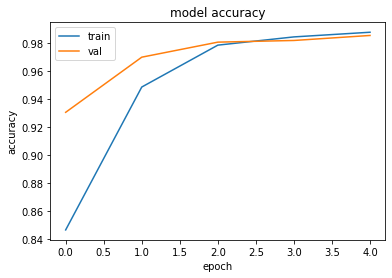

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

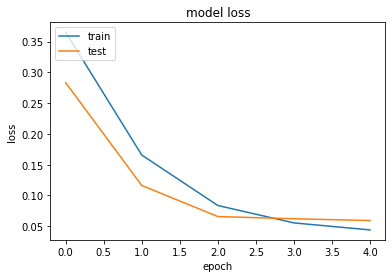

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = rnn.evaluate(x_test, y_test, verbose = 0)


print("Test loss:", score[0], "\nTest accuracy:", score[1])

pred = rnn.predict(x_test)

# Properly assign binary values opposed to float values
pred[pred <= 0.5] = 0.
pred[pred > 0.5] = 1.

matrix = confusion_matrix(y_test, pred)

recall = recall_score(y_test, pred)
prec = precision_score(y_test, pred)
auc = roc_auc_score(y_test, pred)

print("Recall:", recall, "\nPrecision:", prec, "\nAUC:", auc)

matrix

Test loss: 0.048081740736961365 
Test accuracy: 0.9844497442245483
Recall: 0.9035087719298246 
Precision: 0.9809523809523809 
AUC: 0.9503693444136657


array([[720,   2],
       [ 11, 103]])

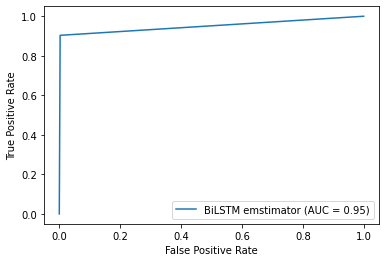

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='BiLSTM emstimator')
display.plot()

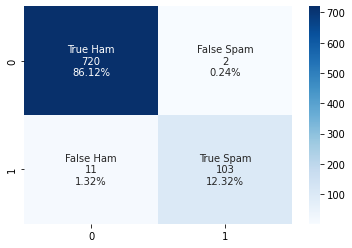

In [ ]:
group_names = ['True Ham','False Spam','False Ham','True Spam']
group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')